<a href="https://colab.research.google.com/github/manahilashfaq/BreathEZ/blob/main/Analysis%2C_visualization_and_building_the_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I will print the outputs of only the first 5 entries for all arrays and lists else you guys have to scroll through a lot to reach the next cell and it also takes a lot of time to commit. If you want to print all the entries, you can fork this kernel and just run a loop until the length of the array or list and print all entries.

In [ ]:
#importing the necessary libraries and dependencies
import pandas as pd
import numpy as np
import seaborn as sns;
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Activation
from keras.optimizers import RMSprop
from keras import optimizers
from keras import backend as K
from keras.layers import Layer
from keras.initializers import RandomUniform, Initializer, Constant
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
class InitCentersRandom(Initializer):
    """ Initializer for initialization of centers of RBF network
        as random samples from the given data set.
    # Arguments
        X: matrix, dataset to choose the centers from (random rows
          are taken as centers)
    """

    def __init__(self, X):
        self.X = X

    def __call__(self, shape, dtype=None):
        assert shape[1] == self.X.shape[1]
        idx = np.random.randint(self.X.shape[0], size=shape[0])
        return self.X[idx, :]


class RBFLayer(Layer):
    """ Layer of Gaussian RBF units.
    # Example
    ```python
        model = Sequential()
        model.add(RBFLayer(10,
                           initializer=InitCentersRandom(X),
                           betas=1.0,
                           input_shape=(1,)))
        model.add(Dense(1))
    ```
    # Arguments
        output_dim: number of hidden units (i.e. number of outputs of the
                    layer)
        initializer: instance of initiliazer to initialize centers
        betas: float, initial value for betas
    """

    def __init__(self, output_dim, initializer=None, betas=1.0, **kwargs):
        self.output_dim = output_dim
        self.init_betas = betas
        if not initializer:
            self.initializer = RandomUniform(0.0, 1.0)
        else:
            self.initializer = initializer
        super(RBFLayer, self).__init__(**kwargs)

    def build(self, input_shape):

        self.centers = self.add_weight(name='centers',
                                       shape=(self.output_dim, input_shape[1]),
                                       initializer=self.initializer,
                                       trainable=True)
        self.betas = self.add_weight(name='betas',
                                     shape=(self.output_dim,),
                                     initializer=Constant(
                                         value=self.init_betas),
                                     # initializer='ones',
                                     trainable=True)

        super(RBFLayer, self).build(input_shape)

    def call(self, x):

        C = K.expand_dims(self.centers)
        H = K.transpose(C-K.transpose(x))
        return K.exp(-self.betas * K.sum(H**2, axis=1))

        # C = self.centers[np.newaxis, :, :]
        # X = x[:, np.newaxis, :]

        # diffnorm = K.sum((C-X)**2, axis=-1)
        # ret = K.exp( - self.betas * diffnorm)
        # return ret

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

    def get_config(self):
        # have to define get_config to be able to use model_from_json
        config = {
            'output_dim': self.output_dim
        }
        base_config = super(RBFLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

from keras.initializers import Initializer
from sklearn.cluster import KMeans


class InitCentersKMeans(Initializer):
    """ Initializer for initialization of centers of RBF network
        by clustering the given data set.
    # Arguments
        X: matrix, dataset
    """

    def __init__(self, X, max_iter=100):
        self.X = X
        self.max_iter = max_iter

    def __call__(self, shape, dtype=None):
        assert shape[1] == self.X.shape[1]

        n_centers = shape[0]
        km = KMeans(n_clusters=n_centers, max_iter=self.max_iter, verbose=0)
        km.fit(self.X)
        return km.cluster_centers_

In [ ]:
# loading the data into the dataframe
df = pd.read_csv('Data_csv') 
print(df) 

          No  year  month  day  hour  PM2.5  PM10   SO2   NO2     CO    O3  \
0          1  2013      3    1     0    4.0   4.0   4.0   7.0  300.0  77.0   
1          2  2013      3    1     1    8.0   8.0   4.0   7.0  300.0  77.0   
2          3  2013      3    1     2    7.0   7.0   5.0  10.0  300.0  73.0   
3          4  2013      3    1     3    6.0   6.0  11.0  11.0  300.0  72.0   
4          5  2013      3    1     4    3.0   3.0  12.0  12.0  300.0  72.0   
...      ...   ...    ...  ...   ...    ...   ...   ...   ...    ...   ...   
35059  35060  2017      2   28    19   12.0  29.0   5.0  35.0  400.0  95.0   
35060  35061  2017      2   28    20   13.0  37.0   7.0  45.0  500.0  81.0   
35061  35062  2017      2   28    21   16.0  37.0  10.0  66.0  700.0  58.0   
35062  35063  2017      2   28    22   21.0  44.0  12.0  87.0  700.0  35.0   
35063  35064  2017      2   28    23   19.0  31.0  10.0  79.0  600.0  42.0   

       TEMP    PRES  DEWP  RAIN   wd  WSPM       station  
0   

In [ ]:
# viewing info about the columns
df.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 18 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   No       35064 non-null  int64  
 1   year     35064 non-null  int64  
 2   month    35064 non-null  int64  
 3   day      35064 non-null  int64  
 4   hour     35064 non-null  int64  
 5   PM2.5    34139 non-null  float64
 6   PM10     34346 non-null  float64
 7   SO2      34129 non-null  float64
 8   NO2      34041 non-null  float64
 9   CO       33288 non-null  float64
 10  O3       33345 non-null  float64
 11  TEMP     35044 non-null  float64
 12  PRES     35044 non-null  float64
 13  DEWP     35044 non-null  float64
 14  RAIN     35044 non-null  float64
 15  wd       34983 non-null  object 
 16  WSPM     35050 non-null  float64
 17  station  35064 non-null  object 
dtypes: float64(11), int64(5), object(2)
memory usage: 4.8+ MB


In [ ]:
#viewing few rows from the top
df.head()

No  year  month  day  hour  PM2.5  PM10   SO2   NO2     CO    O3  TEMP  \
0   1  2013      3    1     0    4.0   4.0   4.0   7.0  300.0  77.0  -0.7   
1   2  2013      3    1     1    8.0   8.0   4.0   7.0  300.0  77.0  -1.1   
2   3  2013      3    1     2    7.0   7.0   5.0  10.0  300.0  73.0  -1.1   
3   4  2013      3    1     3    6.0   6.0  11.0  11.0  300.0  72.0  -1.4   
4   5  2013      3    1     4    3.0   3.0  12.0  12.0  300.0  72.0  -2.0   

     PRES  DEWP  RAIN   wd  WSPM       station  
0  1023.0 -18.8   0.0  NNW   4.4  Aotizhongxin  
1  1023.2 -18.2   0.0    N   4.7  Aotizhongxin  
2  1023.5 -18.2   0.0  NNW   5.6  Aotizhongxin  
3  1024.5 -19.4   0.0   NW   3.1  Aotizhongxin  
4  1025.2 -19.5   0.0    N   2.0  Aotizhongxin

In [ ]:
#number of rows and columns in the dataset
print(df.shape)

(35064, 18)


In [ ]:
#statistical information about columns
print(df.describe())

                 No          year         month           day          hour  \
count  35064.000000  35064.000000  35064.000000  35064.000000  35064.000000   
mean   17532.500000   2014.662560      6.522930     15.729637     11.500000   
std    10122.249256      1.177213      3.448752      8.800218      6.922285   
min        1.000000   2013.000000      1.000000      1.000000      0.000000   
25%     8766.750000   2014.000000      4.000000      8.000000      5.750000   
50%    17532.500000   2015.000000      7.000000     16.000000     11.500000   
75%    26298.250000   2016.000000     10.000000     23.000000     17.250000   
max    35064.000000   2017.000000     12.000000     31.000000     23.000000   

              PM2.5          PM10           SO2           NO2            CO  \
count  34139.000000  34346.000000  34129.000000  34041.000000  33288.000000   
mean      82.773611    110.060391     17.375901     59.305833   1262.945145   
std       82.135694     95.223005     22.823017    

In [ ]:
#checking how many null values are in each column
df.isnull().sum()

No            0
year          0
month         0
day           0
hour          0
PM2.5       925
PM10        718
SO2         935
NO2        1023
CO         1776
O3         1719
TEMP         20
PRES         20
DEWP         20
RAIN         20
wd           81
WSPM         14
station       0
dtype: int64

Just doing `df.dropna()` drops all the NaN values only for the current execution of the cell. If you do the above `df.isnull().sum()` now, you can see that null values still persists. You can solve this by assigning the obtained output of 
`df.dopna()` to the variable `df` which stores our data (dataframe)

In [ ]:
# dropping all the rows with NaN values
df = df.dropna()

In [ ]:
#defining training and testing data
x_train = df[:24865]
y_train = x_train['PM2.5']
x_test = df[24865:31898]
y_test = x_test['PM2.5']
print(y_test)

27669    59.0
27670    53.0
27671    64.0
27672    74.0
27673    78.0
         ... 
35059    12.0
35060    13.0
35061    16.0
35062    21.0
35063    19.0
Name: PM2.5, Length: 6950, dtype: float64


There are many pollutants. Let's first try to predict PM2.5 concentration values. Let the years 2016 and 2017 be the testing set. As you can see below, these 2 years account for 21.9% of the data (test set)

In [ ]:
df.loc[24865:31898].count() / df.shape[0] * 100

No         20.625491
year       20.625491
month      20.625491
day        20.625491
hour       20.625491
PM2.5      20.625491
PM10       20.625491
SO2        20.625491
NO2        20.625491
CO         20.625491
O3         20.625491
TEMP       20.625491
PRES       20.625491
DEWP       20.625491
RAIN       20.625491
wd         20.625491
WSPM       20.625491
station    20.625491
dtype: float64

In [ ]:
#Normalizing training data
train_norm = x_train['PM2.5']

#converted into array as all the methods available are for arrays and not lists
train_norm_arr = np.asarray(train_norm)
train_norm = np.reshape(train_norm_arr, (-1, 1))

#Scaling all values between 0 and 1 so that large values don't just dominate
scaler = MinMaxScaler(feature_range=(0, 1))
train_norm = scaler.fit_transform(train_norm)
for i in range(5):
    print(train_norm[i])

[0.00140845]
[0.00704225]
[0.0056338]
[0.00422535]
[0.]


Even after normalization and scaing, null values are possible (many people disregard this). Let's check if any null values are present.

In [ ]:
count = 0
for i in range(len(train_norm)):
    if train_norm[i] == 0:
        count = count +1
print('Number of null values in train_norm = ', count)

Number of null values in train_norm =  296


In [ ]:
#removing null values 
train_norm = train_norm[train_norm!=0]

In [ ]:
#Normalizing testing data and repeating the same process as done for training data
test_norm = x_test['PM2.5']
test_norm_arr = np.asarray(test_norm)
test_norm = np.reshape(test_norm_arr, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
test_norm = scaler.fit_transform(test_norm)
for i in range(5):
    print(test_norm[i])

[0.07887324]
[0.07042254]
[0.08591549]
[0.1]
[0.1056338]


In [ ]:
count = 0
for i in range(len(test_norm)):
    if test_norm[i] == 0:
        count = count + 1 
print('Number of null values in test_norm = ', count)

Number of null values in test_norm =  129


In [ ]:
#removing null values
test_norm = test_norm[test_norm != 0]

In [ ]:
print(train_norm.shape)
print(test_norm.shape)

(24569,)
(6821,)


Since this is a time series data, we should be predicting the values after looking at a set of values rather than just a single value like we usually do. This takes into account the correlation between the data points and the timestamps. Because the neighbours should be considered for how the values change over time. Let's define a function to do this.

The below function called split_sequence splits the sequence into sets of n values. This n is given as n_steps (step_size). For example, if n=3, we split the sequence in groups of 3. We create 2 empty lists and append the split sequences.

In [ ]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X),array(y)

Here the number of features = 1 as we will be predicting a single value. Let's reshape the split sequences into the format of number of rows, number of columns. (shape[0], shape[1]). In the output, we can see that groups of 3 since n_steps = 3 have been obtained.

In [ ]:
n_steps = 3
X_split_train, y_split_train = split_sequence(train_norm, n_steps)
#for i in range(len(X_split_train)):
    #print(X_split_train[i], y_split_train[i])
n_features = 1
X_split_train = X_split_train.reshape((X_split_train.shape[0], X_split_train.shape[1], n_features))
for i in range(5):
    print(X_split_train)

[[[0.00140845]
  [0.00704225]
  [0.0056338 ]]

 [[0.00704225]
  [0.0056338 ]
  [0.00422535]]

 [[0.0056338 ]
  [0.00422535]
  [0.0028169 ]]

 ...

 [[0.10704225]
  [0.1028169 ]
  [0.08732394]]

 [[0.1028169 ]
  [0.08732394]
  [0.08732394]]

 [[0.08732394]
  [0.08732394]
  [0.08873239]]]
[[[0.00140845]
  [0.00704225]
  [0.0056338 ]]

 [[0.00704225]
  [0.0056338 ]
  [0.00422535]]

 [[0.0056338 ]
  [0.00422535]
  [0.0028169 ]]

 ...

 [[0.10704225]
  [0.1028169 ]
  [0.08732394]]

 [[0.1028169 ]
  [0.08732394]
  [0.08732394]]

 [[0.08732394]
  [0.08732394]
  [0.08873239]]]
[[[0.00140845]
  [0.00704225]
  [0.0056338 ]]

 [[0.00704225]
  [0.0056338 ]
  [0.00422535]]

 [[0.0056338 ]
  [0.00422535]
  [0.0028169 ]]

 ...

 [[0.10704225]
  [0.1028169 ]
  [0.08732394]]

 [[0.1028169 ]
  [0.08732394]
  [0.08732394]]

 [[0.08732394]
  [0.08732394]
  [0.08873239]]]
[[[0.00140845]
  [0.00704225]
  [0.0056338 ]]

 [[0.00704225]
  [0.0056338 ]
  [0.00422535]]

 [[0.0056338 ]
  [0.00422535]
  [0.0028169

You can see below that, we predict the value for the first 3 values, then consider that output as one of the 3 values in the next set. For example, we preedict 0.1 first, then we take that 0.1 as input in the second set and so on.

In [ ]:
X_split_test, y_split_test = split_sequence(test_norm, n_steps)
for i in range(5):
    print(X_split_test[i], y_split_test[i])
n_features = 1
X_split_test = X_split_test.reshape((X_split_test.shape[0], X_split_test.shape[1], n_features))

[0.07887324 0.07042254 0.08591549] 0.1
[0.07042254 0.08591549 0.1       ] 0.10563380281690142
[0.08591549 0.1        0.1056338 ] 0.09295774647887325
[0.1        0.1056338  0.09295775] 0.10845070422535212
[0.1056338  0.09295775 0.1084507 ] 0.11690140845070424


Let's define our neural network (LSTM: Long Short Term Memory). Let's add 50 nodes in our first layer with a ReLU (Rectified linear unit) activation. Their shape will be step size, number of features. Then we will add, a dense layer with one node for the output.

We can try out different optimizers to see which minimizes loss and maximizes accuracy. Stochastic gradient descent (SGD), Adam, AdaBoost, RMSProp are few of them. lr = learning rate, decay = by how much to decay the learning rate, momentum = how much should the gradient descent be accelerated to dampen oscillations, nesterov = whether to use nesterov momentum. Nesterov has stronger convergence for convex functions. And then we compile using MSE (mean squared loss) as our loss function.

In [ ]:
model = Sequential()
rbflayer = RBFLayer(34,
                        initializer=InitCentersKMeans(X_split_train),
                        betas=3.0,
                        input_shape=(568,))
model.add(rbflayer)
model.add(Dense(4))
model.add(Activation('linear'))


AssertionError: ignored

In [ ]:
model.compile(loss='mean_squared_error',
                  optimizer=RMSprop(), metrics=['accuracy'])
print(model.summary())

In [ ]:
history1 = model.fit(X_split_train, y_split_train, epochs=1000, batch_size=32)

In [ ]:
# define model
model = Sequential()
model.add(LSTM(32, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

#sgd = optimizers.SGD(lr=0.001, decay=1e-5, momentum=1.0, nesterov=False)
sgd = optimizers.SGD(lr=0.01, decay=1e-5, momentum=0.9, nesterov=True) #good

#keras.optimizers.RMSprop(learning_rate=0.01, rho=0.9)
keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# fit model
hist = model.fit(X_split_train, y_split_train, validation_data=(X_split_test, y_split_test), epochs=10, verbose = 1)

Epoch 1/10
768/768 [==============================] - 18s 13ms/step - loss: 0.0020 - accuracy: 0.0000e+00 - val_loss: 8.2152e-04 - val_accuracy: 1.4667e-04
Epoch 2/10
768/768 [==============================] - 9s 12ms/step - loss: 9.4167e-04 - accuracy: 4.0707e-05 - val_loss: 0.0011 - val_accuracy: 1.4667e-04
Epoch 3/10
768/768 [==============================] - 9s 11ms/step - loss: 9.2725e-04 - accuracy: 4.0707e-05 - val_loss: 7.6299e-04 - val_accuracy: 1.4667e-04
Epoch 4/10
768/768 [==============================] - 9s 11ms/step - loss: 9.3138e-04 - accuracy: 4.0707e-05 - val_loss: 7.4843e-04 - val_accuracy: 1.4667e-04
Epoch 5/10
768/768 [==============================] - 9s 12ms/step - loss: 9.1868e-04 - accuracy: 4.0707e-05 - val_loss: 6.7966e-04 - val_accuracy: 1.4667e-04
Epoch 6/10
768/768 [==============================] - 9s 12ms/step - loss: 9.0117e-04 - accuracy: 4.0707e-05 - val_loss: 8.7379e-04 - val_accuracy: 1.4667e-04
Epoch 7/10
768/768 [==============================] -

In [ ]:
print(hist.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [ ]:
yhat = model.predict(X_split_test)
for i in range(5):
    print(yhat[i])

214/214 [==============================] - 1s 3ms/step
[0.09237246]
[0.10482045]
[0.1081657]
[0.09130622]
[0.11446875]


In [ ]:
mse = mean_squared_error(y_split_test, yhat)
print('MSE: %.5f' % mse)

MSE: 0.00070


Below, I have plotted the actual true values (first plot) and preedicted values (second plot). One can visually see that the distribution is almost the same. This says that our predictions are very accurate.

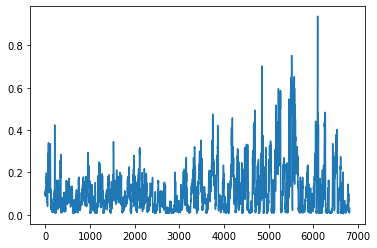

In [ ]:
plt.plot(yhat)

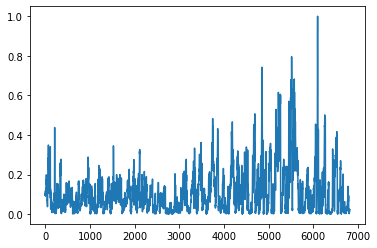

In [ ]:
plt.plot(y_split_test)

In [ ]:
_, train_acc = model.evaluate(X_split_train, y_split_train, verbose=0)
_, test_acc = model.evaluate(X_split_test, y_split_test, verbose=0)
print('Train: %.5f, Test: %.5f' % (train_acc, test_acc))

Train: 0.00004, Test: 0.00015


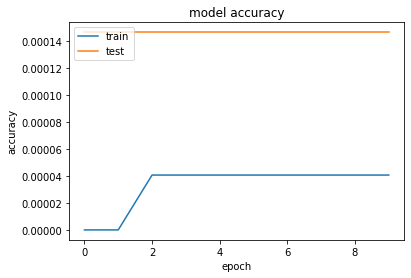

In [ ]:
# summarize history for accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Above, accuracy increase a lot in the last few epochs. Below, the loss gradually decrease. These are positive signs that our model is doing very good.

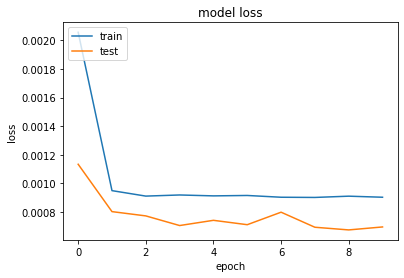

In [ ]:
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Until now, we just ran our model for prediction of a single pollutant. We have 6 pollutants in our dataset and can make predictions for all of them. So, I have made a function which can be used to predict the other pollutants rather than having to write the code again and again. I have commented the function calls. You can fork this kernel to uncomment and predit the other pollutants (Coz it would take up a lot of space and time).

In [ ]:
def compute(var):
    train_norm = x_train[var] 
    train_norm_arr = np.asarray(train_norm)
    train_norm = np.reshape(train_norm_arr, (-1, 1))
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_norm = scaler.fit_transform(train_norm)
    train_norm = train_norm[train_norm != 0]
    
    test_norm = x_test[var]
    test_norm_arr = np.asarray(test_norm)
    test_norm = np.reshape(test_norm_arr, (-1, 1))
    scaler = MinMaxScaler(feature_range=(0, 1))
    test_norm = scaler.fit_transform(test_norm)
    test_norm = test_norm[test_norm != 0]

    X_split_train, y_split_train = split_sequence(train_norm, n_steps)
    X_split_train = X_split_train.reshape((X_split_train.shape[0], X_split_train.shape[1], n_features))

    X_split_test, y_split_test = split_sequence(test_norm, n_steps)
    X_split_test = X_split_test.reshape((X_split_test.shape[0], X_split_test.shape[1], n_features))

    hist = model.fit(X_split_train, y_split_train, validation_data=(X_split_test, y_split_test), epochs=10, verbose = 1)

    yhat = model.predict(X_split_test)

    mse = mean_squared_error(y_split_test, yhat)
    print(mse)
    
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

Epoch 1/10
777/777 [==============================] - 9s 12ms/step - loss: 0.0014 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 1.4399e-04
Epoch 2/10
777/777 [==============================] - 9s 12ms/step - loss: 0.0014 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 1.4399e-04
Epoch 3/10
777/777 [==============================] - 9s 12ms/step - loss: 0.0014 - accuracy: 0.0000e+00 - val_loss: 0.0010 - val_accuracy: 1.4399e-04
Epoch 4/10
777/777 [==============================] - 9s 12ms/step - loss: 0.0014 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 1.4399e-04
Epoch 5/10
777/777 [==============================] - 9s 11ms/step - loss: 0.0014 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 1.4399e-04
Epoch 6/10
777/777 [==============================] - 8s 10ms/step - loss: 0.0014 - accuracy: 0.0000e+00 - val_loss: 0.0013 - val_accuracy: 1.4399e-04
Epoch 7/10
777/777 [==============================] - 9s 12ms/step - loss: 0.0014 - accuracy: 

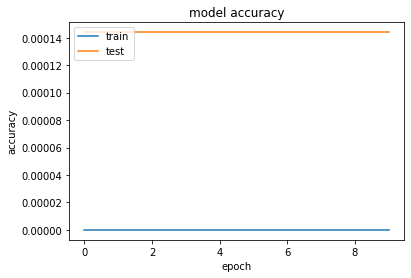

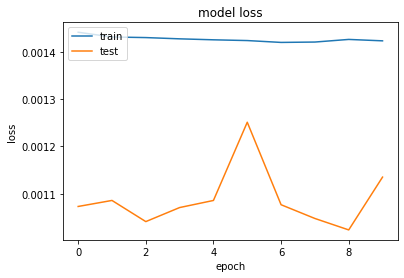

In [ ]:
compute('PM10')

Epoch 1/10
777/777 [==============================] - 9s 12ms/step - loss: 8.8248e-04 - accuracy: 4.0225e-05 - val_loss: 9.3671e-04 - val_accuracy: 2.2604e-04
Epoch 2/10
777/777 [==============================] - 8s 10ms/step - loss: 8.7571e-04 - accuracy: 4.0225e-05 - val_loss: 8.5416e-04 - val_accuracy: 2.2604e-04
Epoch 3/10
777/777 [==============================] - 9s 11ms/step - loss: 8.7983e-04 - accuracy: 4.0225e-05 - val_loss: 8.5376e-04 - val_accuracy: 2.2604e-04
Epoch 4/10
777/777 [==============================] - 9s 12ms/step - loss: 8.7632e-04 - accuracy: 4.0225e-05 - val_loss: 8.3132e-04 - val_accuracy: 2.2604e-04
Epoch 5/10
777/777 [==============================] - 9s 11ms/step - loss: 8.7199e-04 - accuracy: 4.0225e-05 - val_loss: 8.1037e-04 - val_accuracy: 2.2604e-04
Epoch 6/10
777/777 [==============================] - 9s 11ms/step - loss: 8.7762e-04 - accuracy: 4.0225e-05 - val_loss: 9.0369e-04 - val_accuracy: 2.2604e-04
Epoch 7/10
777/777 [==========================

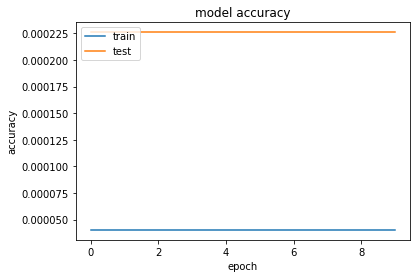

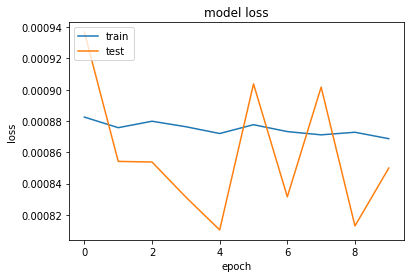

In [ ]:
compute('SO2')

Epoch 1/10
776/776 [==============================] - 9s 12ms/step - loss: 0.0019 - accuracy: 4.0316e-05 - val_loss: 0.0027 - val_accuracy: 1.4430e-04
Epoch 2/10
776/776 [==============================] - 8s 11ms/step - loss: 0.0019 - accuracy: 4.0316e-05 - val_loss: 0.0026 - val_accuracy: 1.4430e-04
Epoch 3/10
776/776 [==============================] - 9s 12ms/step - loss: 0.0019 - accuracy: 4.0316e-05 - val_loss: 0.0026 - val_accuracy: 1.4430e-04
Epoch 4/10
776/776 [==============================] - 10s 13ms/step - loss: 0.0019 - accuracy: 4.0316e-05 - val_loss: 0.0025 - val_accuracy: 1.4430e-04
Epoch 5/10
776/776 [==============================] - 9s 12ms/step - loss: 0.0019 - accuracy: 4.0316e-05 - val_loss: 0.0026 - val_accuracy: 1.4430e-04
Epoch 6/10
776/776 [==============================] - 8s 11ms/step - loss: 0.0019 - accuracy: 4.0316e-05 - val_loss: 0.0025 - val_accuracy: 1.4430e-04
Epoch 7/10
776/776 [==============================] - 9s 12ms/step - loss: 0.0019 - accuracy:

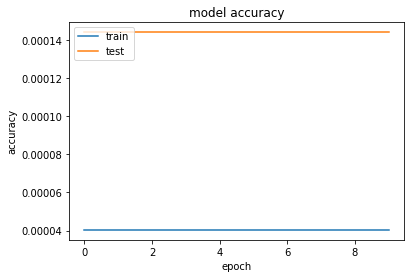

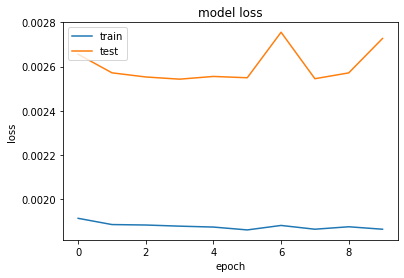

In [ ]:
compute('NO2')

Epoch 1/10
774/774 [==============================] - 10s 13ms/step - loss: 0.0013 - accuracy: 1.2120e-04 - val_loss: 0.0018 - val_accuracy: 2.9189e-04
Epoch 2/10
774/774 [==============================] - 9s 12ms/step - loss: 0.0013 - accuracy: 1.2120e-04 - val_loss: 0.0019 - val_accuracy: 2.9189e-04
Epoch 3/10
774/774 [==============================] - 11s 14ms/step - loss: 0.0013 - accuracy: 1.2120e-04 - val_loss: 0.0018 - val_accuracy: 2.9189e-04
Epoch 4/10
774/774 [==============================] - 10s 13ms/step - loss: 0.0013 - accuracy: 1.2120e-04 - val_loss: 0.0018 - val_accuracy: 2.9189e-04
Epoch 5/10
774/774 [==============================] - 9s 12ms/step - loss: 0.0013 - accuracy: 1.2120e-04 - val_loss: 0.0019 - val_accuracy: 2.9189e-04
Epoch 6/10
774/774 [==============================] - 13s 17ms/step - loss: 0.0013 - accuracy: 1.2120e-04 - val_loss: 0.0020 - val_accuracy: 2.9189e-04
Epoch 7/10
774/774 [==============================] - 10s 13ms/step - loss: 0.0013 - accur

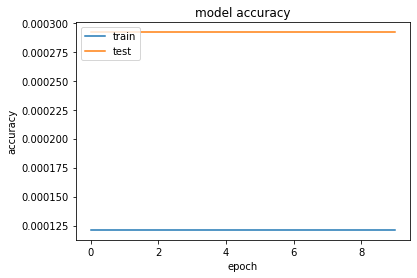

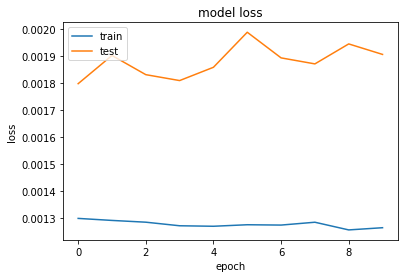

In [ ]:
compute('CO')

Epoch 1/10
777/777 [==============================] - 9s 12ms/step - loss: 0.0012 - accuracy: 4.0232e-05 - val_loss: 0.0024 - val_accuracy: 1.7179e-04
Epoch 2/10
777/777 [==============================] - 8s 11ms/step - loss: 0.0012 - accuracy: 4.0232e-05 - val_loss: 0.0024 - val_accuracy: 1.7179e-04
Epoch 3/10
777/777 [==============================] - 9s 12ms/step - loss: 0.0012 - accuracy: 4.0232e-05 - val_loss: 0.0025 - val_accuracy: 1.7179e-04
Epoch 4/10
777/777 [==============================] - 9s 12ms/step - loss: 0.0012 - accuracy: 4.0232e-05 - val_loss: 0.0024 - val_accuracy: 1.7179e-04
Epoch 5/10
777/777 [==============================] - 10s 13ms/step - loss: 0.0012 - accuracy: 4.0232e-05 - val_loss: 0.0024 - val_accuracy: 1.7179e-04
Epoch 6/10
777/777 [==============================] - 8s 11ms/step - loss: 0.0012 - accuracy: 4.0232e-05 - val_loss: 0.0024 - val_accuracy: 1.7179e-04
Epoch 7/10
777/777 [==============================] - 9s 12ms/step - loss: 0.0012 - accuracy:

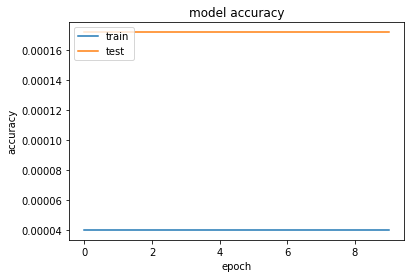

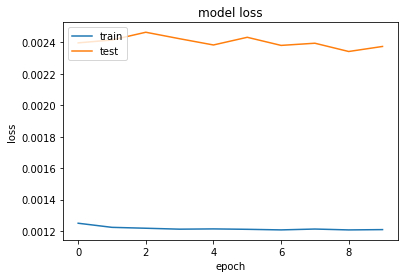

In [ ]:
compute('O3')

Below, we will do a lot of visualizations to understand our data using various scatterplots, jointplots, pairplots, heatmap and correlation.

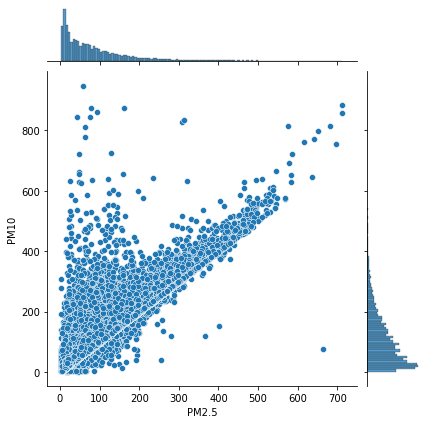

In [ ]:
sns.jointplot(x=df['PM2.5'], y=df['PM10'], data = df)

The above plot gives us the idea that these two conentrations are positively correlated with very few outliers.

<Axes: >

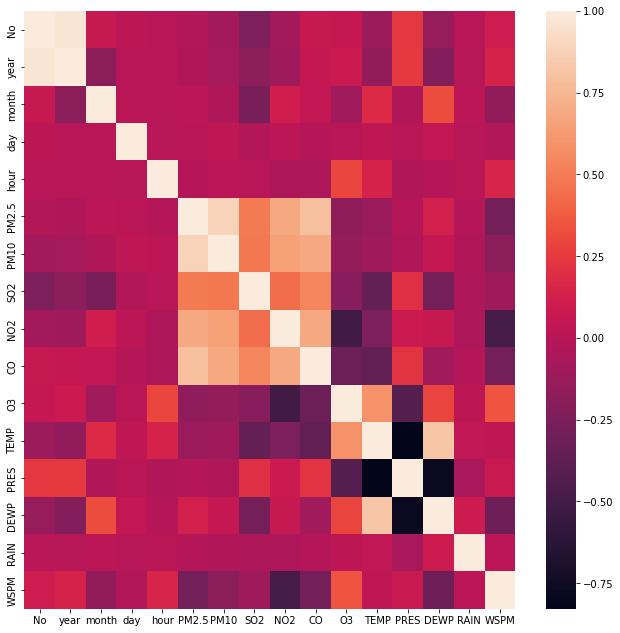

In [ ]:
#finding correlation
corrmat = df.corr()
fig, ax = plt.subplots(figsize=(11,11))
sns.heatmap(corrmat)

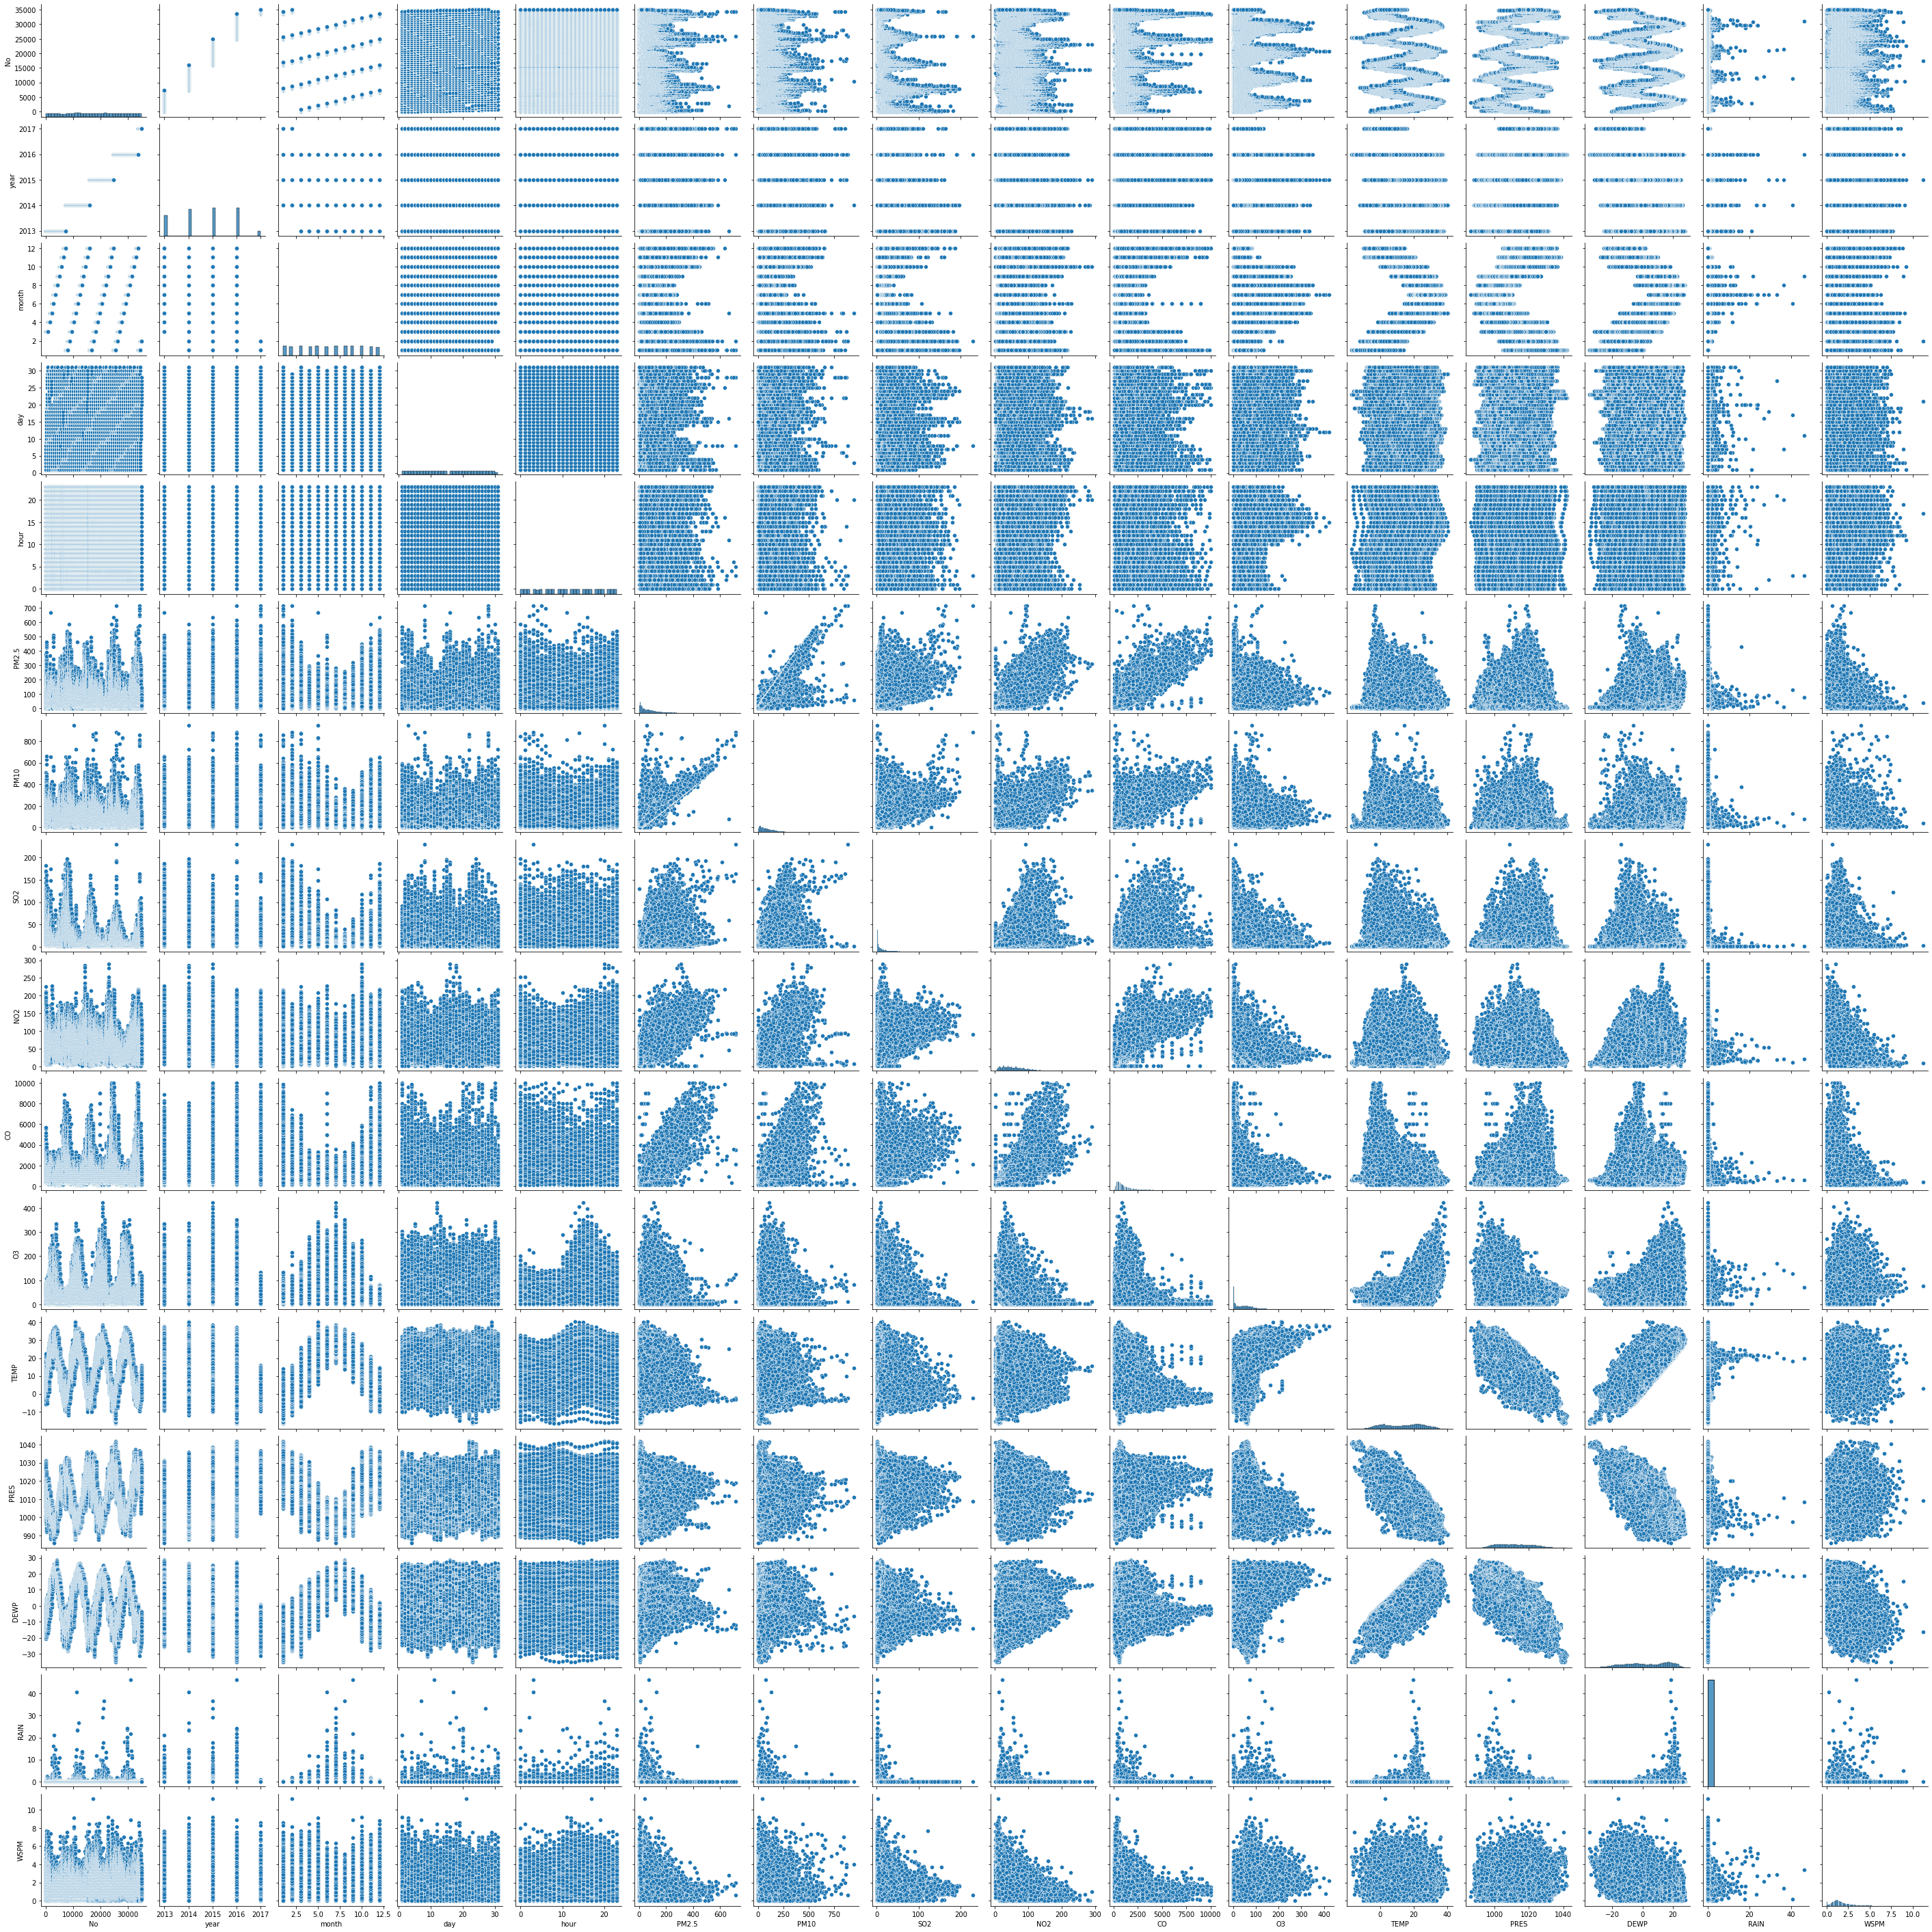

In [ ]:
g = sns.pairplot(df)

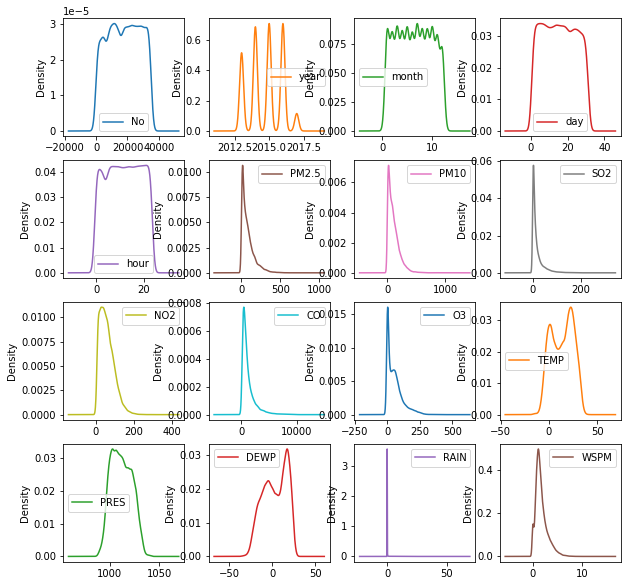

In [ ]:
df.plot(kind='density', subplots=True, layout=(4,4), sharex=False, figsize=(10,10))
plt.show()

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='PM2.5', ylabel='PM10'>

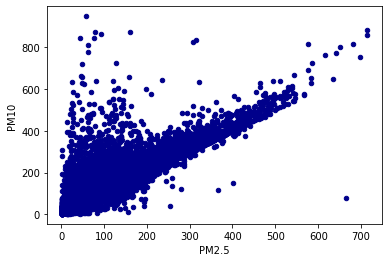

In [ ]:
df.plot.scatter(x='PM2.5', y='PM10', c='DarkBlue')

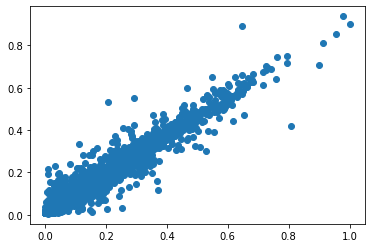

In [ ]:
plt.scatter(y_split_test, yhat)

<Axes: xlabel='PM10', ylabel='SO2'>

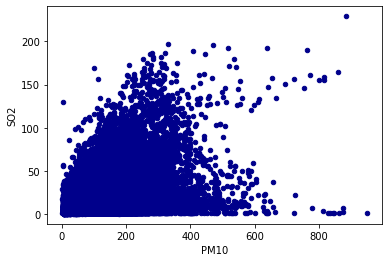

In [ ]:
df.plot.scatter(x='PM10', y='SO2', c='DarkBlue')

<Axes: xlabel='SO2', ylabel='NO2'>

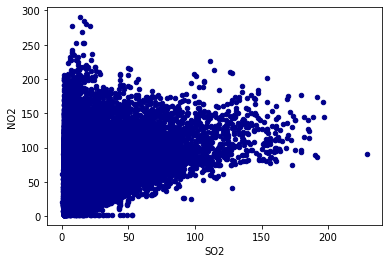

In [ ]:
df.plot.scatter(x='SO2', y='NO2', c='DarkBlue')

<Axes: xlabel='NO2', ylabel='CO'>

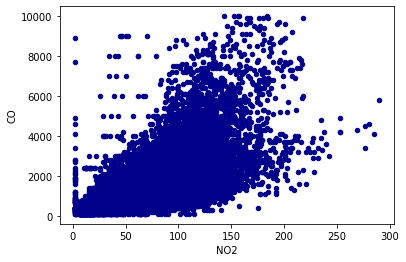

In [ ]:
df.plot.scatter(x='NO2', y='CO', c='DarkBlue')

<Axes: xlabel='CO', ylabel='O3'>

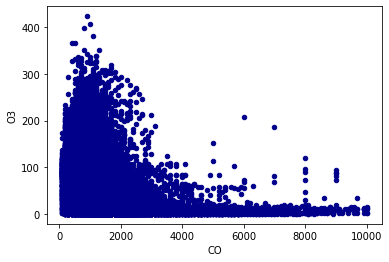

In [ ]:
df.plot.scatter(x='CO', y='O3', c='DarkBlue')

Heatmap is a very useful visualization tool to know how much each feature is correlated. vmax = max value of the heatmap fmt = number of decimal places upto which the value is shown square = do you want the heatmap to be square shaped linewidth = width of the lines in the heatmap annot = should the boxes be labelled with the value.

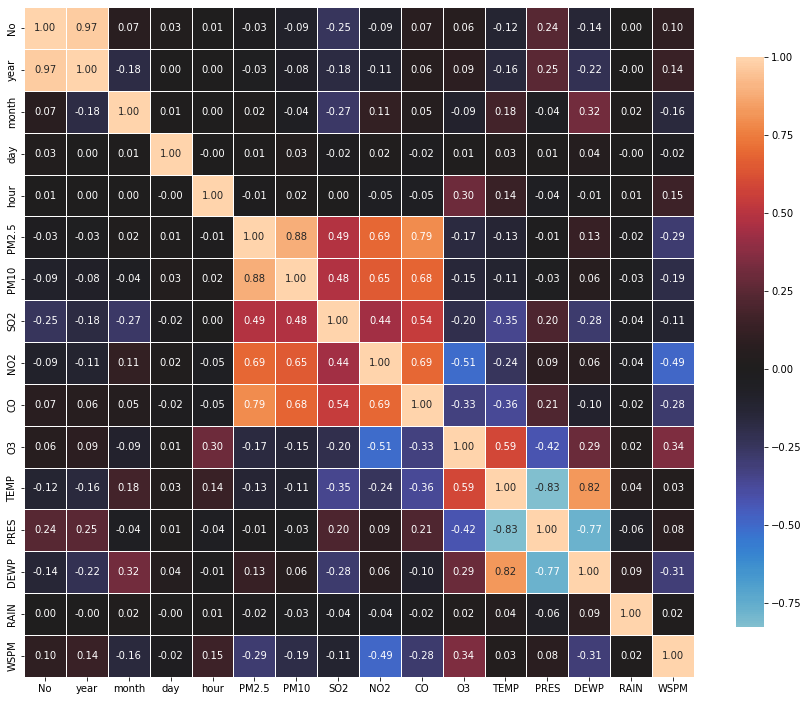

In [ ]:
correlations = df.corr()
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
plt.show();